<a href="https://colab.research.google.com/github/SangMin316/EEG_Data/blob/main/temporal_dynamics_pathway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import glob 
import pandas as pd

path = '/content/drive/MyDrive/sleep_edfx'
data_list = glob.glob(path+'/**')

print(len(data_list))
sample_csv = pd.read_csv(data_list[0])
sample_csv.head(10)

50


,EEG Fpz-Cz
0,25.056899
1,-31.417827
2,-41.904762
3,3.567277
4,-32.363370
5,2.965568
6,-8.982662
7,-26.260317
8,2.879609
9,-26.432234


In [4]:
sample_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6726000 entries, 0 to 6725999
Data columns (total 1 columns):
 #   Column      Dtype  
---  ------      -----  
 0   EEG Fpz-Cz  float64
dtypes: float64(1)
memory usage: 51.3 MB


In [5]:
sample_csv['EEG Fpz-Cz'].value_counts()

-0.042979      57192
 2.707692      16382
 0.472772      16298
 5.458364      16142
 1.332357      16130
               ...  
 171.873993        2
-175.312332        2
-175.828083        1
 173.163370        1
-174.538706        1
Name: EEG Fpz-Cz, Length: 4096, dtype: int64

In [6]:
sample_csv.shape

(6726000, 1)

Cut the data into a sequence of 500 lengths, and then apply augmentation.


In [7]:
sequence_length = 500
def split_data(x):
  a = int(len(x)/sequence_length)
  data = []
  for i in range(a):
    data.append(x[i*sequence_length:(i+1)*sequence_length])
  return data


In [8]:
data = split_data(sample_csv.values)

In [9]:
len(data)

13452

In [10]:
print(len(data[0]))

500


In [11]:
a = data[1]
a.shape

(500, 1)

In [12]:
len(sample_csv)/500

13452.0

*Data* augmentation for single channel

In [13]:
import numpy as np

np.random.seed(42)


def MAF(x,window):
    noise = np.convolve(x, np.ones(window),'same')/window
    x = x - noise
    return x

def asln(x,a,b):
    T = len(x)
    noise = a*np.linspace(0,30,T) - b*np.ones(T)
    n = np.random.randint(2)
    if n == 0:
        new_signals = x + noise
    else:
        new_signals = x - noise
    return new_signals

def apn(x,c,d):
    T = len(x)
    noise =np.sin(np.linspace(-np.pi+d,np.pi+d,T))
    new_signals = x + c*noise
    return new_signals


def augmented_data(x,window,a,b,c,d):
    x = np.reshape(x,(1,sequence_length))
    x = np.squeeze(x)
    x_maf = MAF(x,window)
    x_asln = asln(x,a,b)
    x_apn = apn(x,c,d)
    x = np.array([x ,x_maf, x_asln, x_apn])
    x = np.squeeze(x)
    #one-hot encoding
    label = np.eye(4)
    return x, label
    

Data augmentation for multiple channels

In [ ]:
np.random.seed(42)

def MAF(x,window):
    noise = np.convolve(x, np.ones(window),'same')/window
    x = x - noise
    return x
    
def asln(x,a,b):

    C,T = x.shape
    noise = a*np.linspace(0,T,10) - b*np.one(T)
    noise = noise*np.ones((C,1))
    n = np.random.randint(2)
    if n = 0:
        new_signals = x + noise
    else:
        new_signals = x - noise
    return new_signals

def apn(x,c,d):
    C,T = x.shape
    noise = np.linspace(-np.pi+d,np.pi+d,T) - b*np.one(T)
    noise = c*np.sin(noise)
    new_signals = x + 
    return new_signals


def augmented_data(x,window,a,b,c,d):
    x = np.reshape(x,(1,sequence_length))
    x = np.squeeze(x)
    x_maf = MAF(x,window)
    x_asln = asln(x,a,b)
    x_apn = apn(x,c,d)
    x = np.array([x ,x_maf, x_asln, x_apn])
    x = np.squeeze(x)
    #one-hot encoding
    label = np.eye(4)
    return x, label
    

In [14]:
a = data[0]
x,y = augmented_data(a,20,2,0.3,20,0)
print(x.shape)
print(y)

(4, 500)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Plot the augmented signals

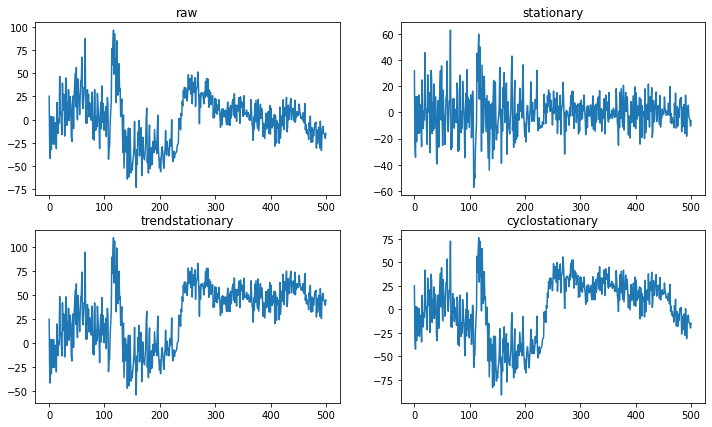

In [16]:
import matplotlib.pyplot as plt

t = np.linspace(0,500,500)
plt.figure(figsize =(12, 7))
label = ['raw', 'stationary','trendstationary','cyclostationary']

for i in range(4):
  y = x[i]
  plt.subplot(2, 2, i+1)
  plt.plot(t,y)
  plt.title(label[i])
  
plt.show()  

We couldn't find the process of uploading augmented files to a custom dataset, so we chose this method as a temporary measure.


In the future, we will implement uploading it to the data loader without saving it.

In [ ]:
for j in range(len(data_list)):
  sample_csv = pd.read_csv(data_list[j])
  data = split_data(sample_csv.values)
  for i in range(len(data)):
    x,y = augmented_data(data[i],20,2,0.3,20,0)
    for k in range(3):
      x1 = x[k]
      y1 = y[k] 
      np.savez_compressed('/content/drive/MyDrive/sleep_edfx/500npz/%s_%s_%s.npz' %(i,j,k),x=x1,y=y1)

CustomDataset

In [39]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):
  def __init__(self, files, sequence_length):
    self.files = files
    self.sequence_length = sequence_length

  def __len__(self):
    return len(self.files)

  def __get__item__(self,i):
    file = self.files[i]
    data = np.load(file)['x']
    label = np.load(file)['y']
    return {'data' : data,'label':label}    
    #return {'data' : torch.tensor(data, dtype=torch.float32),'label' : torch.tensor(label, dtype=torch.long)}

In [64]:
file = train[0]
data = np.load(file)['x']


In [40]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
path = '/content/drive/MyDrive/sleep_edfx/500npz'
train = sorted(glob.glob(path+'/*'))

train, val = train_test_split(train, test_size=0.3)



In [41]:
train_dataset = CustomDataset(train, 500)
val_dataset = CustomDataset(val, 500)

In [60]:
batch_size = 2

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


model

In [43]:
pip install separableconv-torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import torch
import torch.nn as nn
import separableconv.nn as nns


class feature_extractor3(nn.Module):
    def __init__(self):
        super(feature_extractor3,self).__init__()
        
        self.channels = 1 # we use only single channel 
        
        # Regularizer
        #self.regularizer = tf.keras.regularizers.L1L2(l1=.001, l2=.01)

        # Activation functions
        self.activation = nn.LeakyReLU()

        self.softmax = nn.Softmax()
        self.conv1t = nns.SeparableConv2d(1,16,(1,10)) # (in_channels, out_channels, kernel size,,,)
        self.conv1s = nn.Conv2d(16,16,(self.channels,1))
        self.conv2t = nns.SeparableConv2d(16,32,(1,10))
        self.conv2s = nn.Conv2d(32,32,(self.channels,1))
        self.conv3t = nns.SeparableConv2d(32,64,(1,10))
        self.conv3s = nn.Conv2d(64,64,(self.channels,1))
        
        # Flatteninig
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Decision making
        self.Linear = nn.Linear(64*473,4) # 
         
        
    def embedding(self, x, random_mask=False):

        x = self.activation(self.conv1t(x))
        f1 = self.activation(self.conv1s(x))

        x = self.activation(self.conv2t(x))
        f2 = self.activation(self.conv2s(x))

        x = self.activation(self.conv3t(x))
        f3 = self.activation(self.conv3s(x))
        

        # multi-scale feature representation by exploiting intermediate features
        feature = torch.cat((f1, f2, f3), 0)
        return feature

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.Linear(feature))
        return y_hat    

In [45]:
model = feature_extractor3()
print(model)

feature_extractor3(
  (activation): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=None)
  (conv1t): SeparableConv2d(
    (dwconv): Conv2d(1, 1, kernel_size=(1, 10), stride=(1, 1))
    (dwconv_normalization): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dwconv_activation): ReLU()
    (pwconv): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    (pwconv_normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pwconv_activation): ReLU()
  )
  (conv1s): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv2t): SeparableConv2d(
    (dwconv): Conv2d(16, 16, kernel_size=(1, 10), stride=(1, 1), groups=16)
    (dwconv_normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dwconv_activation): ReLU()
    (pwconv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (pwconv_normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_runni